In [117]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

In [15]:
# Config (should ideally be stored in output)
dt = 0.001;
GRAVITY = -10.0;
T = np.array(range(X.shape[0])) * dt;

In [3]:
# Load state
X = np.loadtxt('opencl/output.csv', delimiter=';')
# Group state into 3d array
# (time, state dimension, particle)
X = df.values.reshape(df.shape[0], int(df.shape[1] / 4), 4)

# Load dissipation
# Columns: energyFluxLow, energyFluxHigh, dissipation
df_dissipation = ('opencl/dissipation.csv', delimiter=';', columns=['friction', 'energyFluxLower', 'energyFluxUpper'])
df_dissipation.index = T

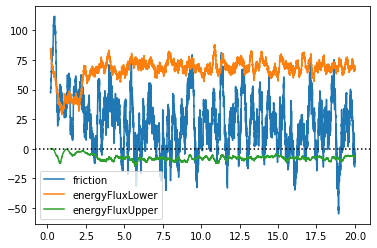

In [38]:
df_dissipation.rolling(200).mean().plot().axhline(0, linestyle=':', color='k')

In [42]:
df = df_dissipation.copy()

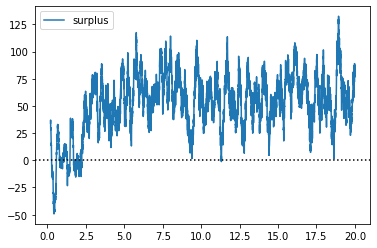

In [37]:
df['surplus'] = df['energyFluxLower'] - df['energyFluxUpper'] - df['friction']
df[['surplus']].rolling(200).mean().plot().axhline(0, linestyle=':', color='k');

The structure, located in a gradient field, seems to maximise its surplus.
There are two gradients:
- the gradient between energy input and output (where output is *both* the upper interface and the friction dissipation)
- the gradient between low and high temperature (which creates a difference on which work can be performed)

In [78]:
# Angular momentum
p = 0.8
theta = np.arctan2(X[:, :, 1], X[:, :, 0])  # this is the angle
theta_dot = np.mod(np.diff(theta, axis=0) + np.pi, 2*np.pi) - np.pi  # this is the dot (angular velocity)
df['angular_momentum_median'] = pd.Series(np.median(theta_dot, axis=1), index=T[1:])
df['angular_momentum_mean'] = pd.Series(np.mean(theta_dot, axis=1), index=T[1:])

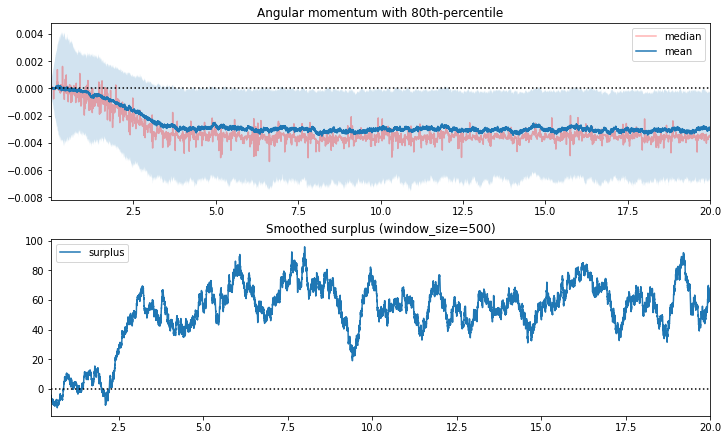

In [108]:
fig, axs = plt.subplots(figsize=(10, 6), nrows=2, constrained_layout=True)
ax = axs[0]
ax.fill_between(T[1:], np.percentile(theta_dot, 100 - p*100, axis=1), np.percentile(theta_dot, p*100, axis=1), alpha=0.2, linewidth=0)
df['angular_momentum_mean'].plot(color='red', ax=ax, alpha=0.3)
df['angular_momentum_median'].plot(ax=ax)
ax.axhline(0, linestyle=':', color='k')
ax.title.set_text(f'Angular momentum with {int(p*100)}th-percentile');
ax.legend(['median', 'mean']);
ax.autoscale(enable=True, axis='x', tight=True)  # 

ax = axs[1]
# df[['surplus']].plot(ax=ax, alpha=0.2);
window_size = 500
df[['surplus']].rolling(window_size).mean().plot(ax=ax).axhline(0, linestyle=':', color='k');
ax.title.set_text(f'Smoothed surplus (window_size={window_size})');
ax.autoscale(enable=True, axis='x', tight=True)

What is interesting to note is that the angular momentum is denoised by taking the average over particules, whereas the surplus is denoise by taking a time average

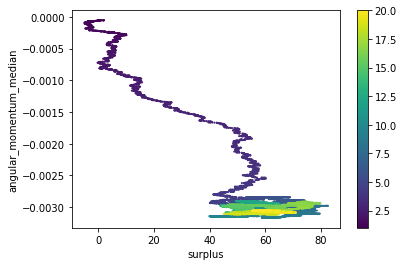

In [72]:
fig, ax = plt.subplots()
df.rolling(1000).mean().plot.scatter(
    y='angular_momentum_median',
    x='surplus',
    c=df.index,
    cmap=plt.get_cmap('viridis'),
    s=1, # point size
    ax=ax,
);

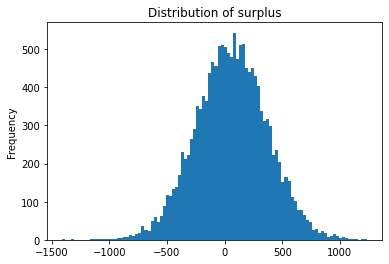

In [124]:
# Distribution of surplus
df.loc[df.index > 5, 'surplus'].plot.hist(bins=100, title='Distribution of surplus');

No structure: it is gaussian

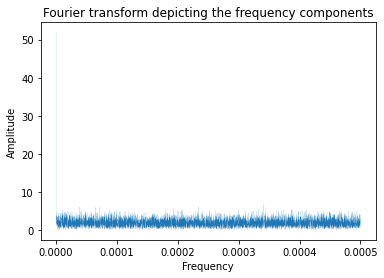

In [126]:
# Frequency analysis of surplus
amplitude = df['surplus']
samplingFrequency = dt

fourierTransform = np.fft.fft(amplitude)/len(amplitude)           # Normalize amplitude
fourierTransform = fourierTransform[range(int(len(amplitude)/2))] # Exclude sampling frequency

tpCount     = len(amplitude)
values      = np.arange(int(tpCount/2))
timePeriod  = tpCount/samplingFrequency
frequencies = values/timePeriod

fig, ax = plt.subplots();
ax.set_title('Fourier transform depicting the frequency components')
ax.plot(frequencies, abs(fourierTransform), linewidth=0.1)
ax.set_xlabel('Frequency');
ax.set_ylabel('Amplitude');
#ax.set_ylim([0, 5])

It has all frequencies! No distinctive period found. Signal seems to look like a stockmarket series / random walk.